In [1]:
import torch
import torchvision
import torchaudio 
import os
import torch.nn as nn
from os.path import isfile, join, isdir, exists
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
class MusicDataset(Dataset):

    def __init__(self, spec_dir, out_dir, years):
        self.spec_dir = spec_dir
        self.out_dir = out_dir
        self.ims = []
        self.labels = []
        self.names = []

        for dirs in years:
            for f in os.listdir(join(spec_dir, dirs)):
                if(isfile(join(join(out_dir, dirs), f))):
                    self.ims.append(join(join(spec_dir, dirs), f))
                    onm = join(out_dir, dirs)
                    self.labels.append(join(onm, f))
                    self.names.append(join(join(out_dir, dirs), f))
                    #print(join(join(spec_dir, dirs), f))
                    #print(join(onm, f))

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, idx):
        #print(self.ims[idx])
        
        im, lab = torch.load(self.ims[idx]), torch.load(self.labels[idx])
        if(im.isnan().any()):
            print(self.names[idx])
        mean = torch.mean(im)
        std = torch.std(im)
        if(std==0):
            im = torch.zeros_like(im)
        else:
            im = (im-mean)/(std)

        if(im.isnan().any()):
            print(self.names[idx], "post", mean, std)
            im = torch.zeros_like(im)

        return im, lab

bs = 32
training_data = MusicDataset('mel/', 'mid/', ['2004', '2006', '2008', '2009', '2011', '2013', '2014'])
test_data = MusicDataset('mel/', 'mid/', ['2015', '2017', '2018'])
train_dataloader = DataLoader(training_data, batch_size=bs, shuffle=True, )
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=False)

In [3]:
# 229 x 1001 input
# 88 x 7681 output

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.ds1 = dsResConvBlock(1, 16)
        self.ds2 = dsResConvBlock(16, 64)
        self.cnn1 = nn.Conv2d(64, 64, 3, 1, padding='same')
        self.cnn2 = nn.Conv2d(64, 64, 3, 1, padding='same')
        self.us1 = usResConvBlock(64, 16)
        self.us2 = usResConvBlock(32, 4, out_size = (88, 7680+5))
        self.ReLU = nn.Tanh()
        self.conv1 = nn.Conv1d(352, 88, 6)
        #self.linear = nn.Linear(4*6*88, 88)

    def forward(self, x):
        y = self.ds1(x)
        res1 = y
        y = self.ds2(y)
        res2 = y
        y = self.cnn1(y)
        y = self.cnn2(y)
        y = self.ReLU(y + res2)
        y = self.us1(y)
        # print(y.shape, res1.shape)
        y = torch.cat((res1, y), axis=1)
        y = self.us2(y)
        output = self.conv1(y.reshape(-1, 4*88, 7685))
        output = nn.Sigmoid()(output)
        #output = torch.zeros((y.shape[0], 88, 7680)).to('cuda')
        # print(y.shape)
        # for i in range(7680):
        #     # print(y[:, :, :, i:i+6].shape)
        #     tp = y[:, :, :, i:i+6].reshape(-1, 4*6*88)
        #     # print(tp.shape)
        #     output[:, :, i] = nn.Sigmoid()(self.linear(tp))
        
        return output


class dsResConvBlock(nn.Module):
    def __init__(self, num_in, num_out):
        super(dsResConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_in, num_out, (3, 3), (1,1), padding='same')
        self.conv2 = nn.Conv2d(num_out, num_out, (3, 3), (1,1), padding='same')
        self.bn = nn.BatchNorm2d(num_out, momentum=0.9, eps=1e-5)
        self.mp = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.ReLU = nn.Tanh()

    def forward(self, x):
        residual = self.ReLU(self.conv1(x))
        y = (self.conv2(residual))
        #y = self.bn(y)
        y = self.ReLU(y + residual)
        y = self.mp(y)
        return y

class usResConvBlock(nn.Module):
    def __init__(self, num_in, num_out, out_size = (1,1)):
        super(usResConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_in, num_out, (3, 3), (1,1), padding='same')
        self.conv2 = nn.Conv2d(num_out, num_out, (3, 3), (1,1), padding='same')
        self.bn = nn.BatchNorm2d(num_out, momentum=0.9, eps=1e-5)
        self.ReLU = nn.Tanh()
        self.out_size = out_size

    def forward(self, x):
        # print("forward 1", x.shape)
        residual = self.ReLU(self.conv1(x))
        y = (self.conv2(residual))
        y = self.ReLU(y + residual)
        # print("forward 2", y.shape)
        if(self.out_size == (1,1)):
            # print("s\n")
            y = nn.Upsample(scale_factor = 2, mode='bilinear')(y)
        else:
            # print("a\n", self.out_size)
            y = nn.Upsample(size = self.out_size, mode='bilinear')(y)
        # print("foward 3")


        return y

def loss_func(x, y):
    # metric = nn.BCELoss()
    # return metric(x.flatten(), (y.flatten()))
    x = torch.clip(x, min=1e-20, max=1-1e-20)
    if(x.isnan().any()):
        print("ANSH IS A GOON!")
    #return torch.mean(y*torch.log(x)*0.95 + (-1*y+1)*torch.log(-1*x+1)*0.05)*-1
    return torch.mean(y*torch.log(x) + (-1*y+1)*torch.log(-1*x+1))*-1
# a = torch.zeros((5, 5))
# y = torch.ones((5, 5))*0
 
# print(loss_func(a, y))

In [4]:
model = Model()
model = model.to('cuda')
lr = 3e-4
optim = torch.optim.Adam(lr = lr, params = model.parameters())
save_epochs = 1
val_print_ep = 5
n_epochs = 100
losses = []
for i in range(n_epochs):
    print("starting epoch", i)
    total_loss = 0
    batch = 0
    intlosses = []
    for X, y in train_dataloader:
        print("batch progress", batch, len(train_dataloader))
        batch += 1
        if(batch % 30 == 0):
            torch.save({
            'epoch': i,
            'batch': batch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': intlosses,
            }, 'intermediate_save_no_weight_conv1d' + str(batch) + '.pt')
        
        X = torch.unsqueeze(X, axis = 1)
        X = X.to('cuda')
        if(X.isnan().any()):
            print("HI")
        # print(X.shape)
        y = y.type(torch.float32).to('cuda')
        optim.zero_grad()
        pred = model(X)
        loss = loss_func(pred, y)
        print(loss.item())
        intlosses.append(loss.item())
        ##print(intlosses)
        total_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optim.step()
    losses.append(total_loss)
    print(total_loss)
    if (i % save_epochs == 0):
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses,
            }, 'saved_data.pt')

    if (i % val_print_ep == 0):
        with torch.no_grad():
            total_loss = 0
            for X, y in test_dataloader:
                X = torch.unsqueeze(X, axis = 1)
                X = X.to('cuda')
                y = y.to('cuda')
                pred = model(X)
                loss = loss_func(y, pred)
                total_loss += loss
        print("Test error after epoch " + str(i) + ": " + str(total_loss/len(test_dataloader)))

starting epoch 0
batch progress 0 1574
0.6940241456031799
batch progress 1 1574
0.6479624509811401
batch progress 2 1574
0.5764980912208557
batch progress 3 1574
0.4817260503768921
batch progress 4 1574
0.3808763325214386
batch progress 5 1574
0.2881995439529419
batch progress 6 1574
0.21146449446678162
batch progress 7 1574
0.17115511000156403
batch progress 8 1574
0.13005509972572327
batch progress 9 1574
0.12491075694561005
batch progress 10 1574
0.10715828835964203
batch progress 11 1574
0.10104161500930786
batch progress 12 1574
0.11143980920314789
batch progress 13 1574
0.11688819527626038
batch progress 14 1574
0.10661359876394272
batch progress 15 1574
0.11364224553108215
batch progress 16 1574
0.11489248275756836
batch progress 17 1574
0.12286404520273209
batch progress 18 1574
0.11128325015306473
batch progress 19 1574
0.10773585736751556
batch progress 20 1574
0.12434972822666168
batch progress 21 1574
0.11375273019075394
batch progress 22 1574
0.10066567361354828
batch prog

KeyboardInterrupt: 

torch.Size([229, 1001])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[1.2967e-04, 1.2967e-04, 1.2967e-04,  ..., 8.0682e-05,
          8.0682e-05, 8.0682e-05],
         [1.5203e-04, 1.5203e-04, 1.5203e-04,  ..., 1.5016e-04,
          1.5016e-04, 1.5016e-04],
         [1.6235e-04, 1.6235e-04, 1.6235e-04,  ..., 8.6071e-05,
          8.6071e-05, 8.6071e-05],
         ...,
         [9.8303e-05, 9.8303e-05, 9.8303e-05,  ..., 2.9688e-05,
          2.9688e-05, 2.9688e-05],
         [6.5723e-05, 6.5723e-05, 6.5723e-05,  ..., 2.7986e-05,
          2.7986e-05, 2.7986e-05],
         [8.0614e-05, 8.0614e-05, 8.0614e-05,  ..., 4.1776e-05,
          4.1776e-05, 4.1776e-05]]]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..

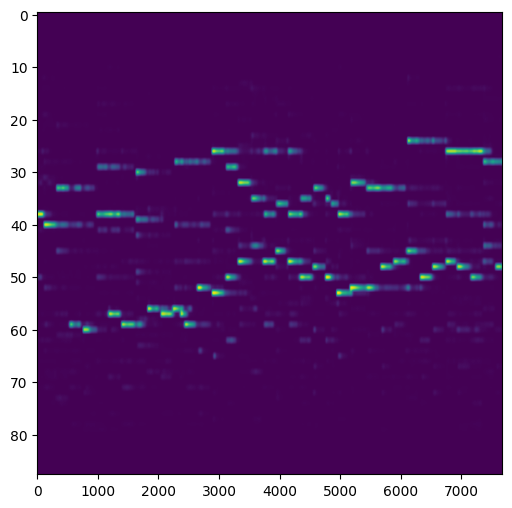

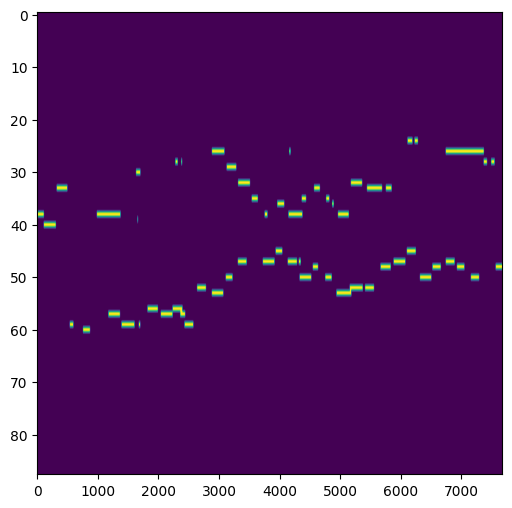

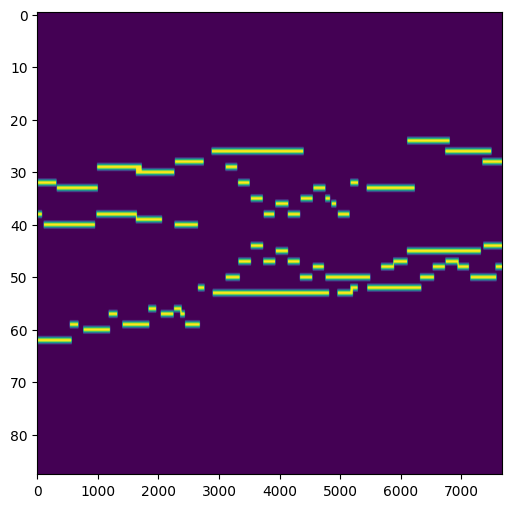

In [ ]:
tt = DataLoader(test_data, batch_size=1, shuffle=False)
meval = Model()
checkpoint = torch.load('intermediate_save_no_weight_conv1d1560.pt')
meval.load_state_dict(checkpoint['model_state_dict'])
meval.train()
fname = "mel/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
X = torch.load(fname)
print(X.shape)
fname = "mid/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
y = torch.load(fname).type(torch.float32)
X = torch.unsqueeze(X, axis = 0)
X = torch.unsqueeze(X, axis = 0)
# X = X.to('cuda')
# y = y.to('cuda')
# print(nn.CrossEntropyLoss()(y, pred[0, :, :]))

with torch.no_grad():    
    pred = meval(X).to('cpu')
    #print(nn.BCELoss()(pred[0, :, :], y))

print(np.round(pred.to('cpu')))

print(pred, y)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(pred[0, :, :], aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(np.round(pred[0, :, :]), aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(y, aspect='auto')
# print(y.shape, pred.shape)
        
print(torch.max(pred))
lll = [0.4915196895599365, 0.394779771566391, 0.2694735825061798, 0.17687253654003143, 0.09298969060182571, 0.05821599066257477, 0.0368744395673275, 0.0269914623349905, 0.023477263748645782, 0.024886222556233406]

torch.Size([229, 1001])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[5.9951e-07, 5.9951e-07, 5.9951e-07,  ..., 2.6805e-03,
          2.6805e-03, 2.6805e-03],
         [7.2796e-05, 7.2796e-05, 7.2796e-05,  ..., 4.3299e-02,
          4.3299e-02, 4.3299e-02],
         [7.2446e-08, 7.2446e-08, 7.2446e-08,  ..., 5.4316e-03,
          5.4316e-03, 5.4316e-03],
         ...,
         [1.2086e-05, 1.2086e-05, 1.2086e-05,  ..., 8.2983e-04,
          8.2983e-04, 8.2983e-04],
         [3.2740e-06, 3.2740e-06, 3.2740e-06,  ..., 1.5123e-03,
          1.5123e-03, 1.5123e-03],
         [1.7856e-06, 1.7856e-06, 1.7856e-06,  ..., 4.3407e-04,
          4.3407e-04, 4.3407e-04]]]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..

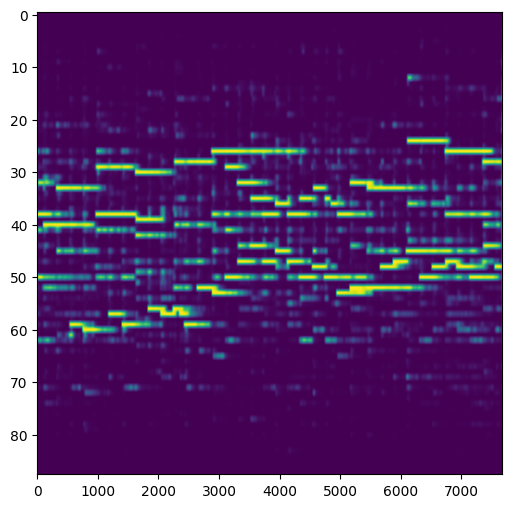

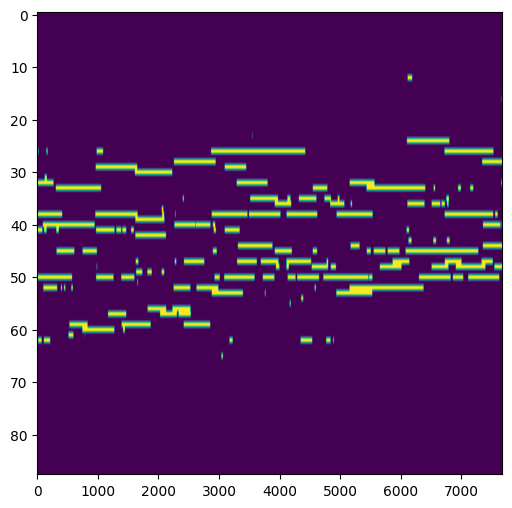

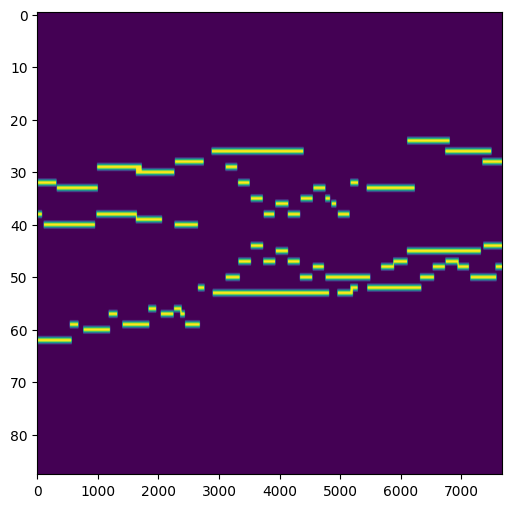

In [ ]:
tt = DataLoader(test_data, batch_size=1, shuffle=False)
meval = Model()
checkpoint = torch.load('intermediate_save750.pt')
meval.load_state_dict(checkpoint['model_state_dict'])
meval.train()
fname = "mel/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
X = torch.load(fname)
print(X.shape)
fname = "mid/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
y = torch.load(fname).type(torch.float32)
X = torch.unsqueeze(X, axis = 0)
X = torch.unsqueeze(X, axis = 0)
# X = X.to('cuda')
# y = y.to('cuda')
# print(nn.CrossEntropyLoss()(y, pred[0, :, :]))

with torch.no_grad():    
    pred = meval(X).to('cpu')
    #print(nn.BCELoss()(pred[0, :, :], y))

print(np.round(pred.to('cpu')))

print(pred, y)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(pred[0, :, :], aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(np.round(pred[0, :, :]), aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(y, aspect='auto')
# print(y.shape, pred.shape)
        
print(torch.max(pred))
lll = [0.4915196895599365, 0.394779771566391, 0.2694735825061798, 0.17687253654003143, 0.09298969060182571, 0.05821599066257477, 0.0368744395673275, 0.0269914623349905, 0.023477263748645782, 0.024886222556233406]